In [1]:
import numpy as np
import xarray as xr
import os
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
outdir='/work/jet/data/interim/'

swmt_prd_cm4 = '0081to0090'
swmt_prd_om4 = '1978to1987'
north = '300S'
lstr = 'sigma2'
dl = '010'
val_cm4 = '3710'
val_om4 = '3725' #3725

var_str1,var1 = 'Fmap','total'
var_str2,var2 = 'bottom_age','bottom_age' #bottom_age_norm_so,bottom_age_norm

In [3]:
mods = ['CM4_piControl_c192_OM4p125_v7','CM4_piControl_c192_OM4p125_v6_alt1','CM4_piControl','OM4p25_JRA55do1.4_0netfw_cycle2']
#'CM4_piControl_c192_OM4p125_v6_alt2','CM4_piControl_c192_OM4p125_v6_alt3'

ddict = {mod:{} for mod in mods}

for mod in ddict:
    swmt_prd = swmt_prd_cm4 if mod[:3]=='CM4' else swmt_prd_om4
    #val = val_cm4 if mod[:3]=='CM4' else val_om4
    val = val_cm4 if mod in ['CM4_piControl_c192_OM4p125_v6_alt1','CM4_piControl'] else '3720' if mod== 'CM4_piControl_c192_OM4p125_v7' else val_om4
    dset1 = '_so_%s_southof%s_%s_%s_%s_at%s'%(swmt_prd,north,var_str1,lstr,dl,val)
    dset2 = '_so_*_southof%s_%s'%(north,var_str2)
    var_names = {var1: dset1, var2: dset2}
    for var in var_names:
        
        if var=='total':
            fname = '%s%s.nc'%(mod,var_names[var])
            
            print('Loading '+fname)
            ddict[mod]['swmt'] = xr.open_dataset(outdir+fname)[var]
        else:
            files = glob.glob(outdir+'%s%s.nc'%(mod,var_names[var]))
            
            if len(files)>1:
                print('WARNING: More than one file for '+var+' in '+mod)
            elif len(files)==0:
                print('ERROR: No file available for '+var+' in '+mod,'%s%s.nc'%(mod,var_names[var]))
                continue
            
            print('Loading '+os.path.basename(files[0]))
            ddict[mod][var] = xr.open_dataset(files[0])

Loading CM4_piControl_c192_OM4p125_v7_so_0081to0090_southof300S_Fmap_sigma2_010_at3720.nc
Loading CM4_piControl_c192_OM4p125_v7_so_0001to0090_southof300S_bottom_age.nc
Loading CM4_piControl_c192_OM4p125_v6_alt1_so_0081to0090_southof300S_Fmap_sigma2_010_at3710.nc
Loading CM4_piControl_c192_OM4p125_v6_alt1_so_0001to0200_southof300S_bottom_age.nc
Loading CM4_piControl_so_0081to0090_southof300S_Fmap_sigma2_010_at3710.nc
Loading CM4_piControl_so_0001to0650_southof300S_bottom_age.nc
Loading OM4p25_JRA55do1.4_0netfw_cycle2_so_1978to1987_southof300S_Fmap_sigma2_010_at3725.nc
Loading OM4p25_JRA55do1.4_0netfw_cycle2_so_1958to2017_southof300S_bottom_age.nc


In [4]:
import cmocean.cm as cmo
import matplotlib.colors as mcolors
from matplotlib.offsetbox import AnchoredText
import cartopy
import sys
sys.path.append('/home/Jan-erik.Tesdal/wmt-inert-tracer/scripts/tools')
from plot import get_so_map_boundary
circle = get_so_map_boundary()

In [6]:
ageb_yr_cm4 = '0090'
ageb_yr_om4 = '1987'
mstr = ['Odiv-209','Odiv-200','Odiv-1','OM4 (JRA, cycle 2)']

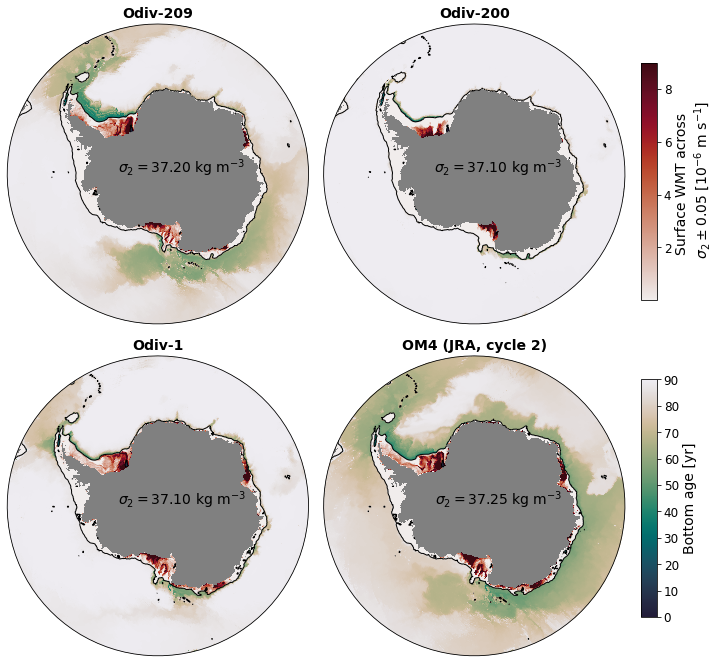

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11,11), subplot_kw=dict(projection=cartopy.crs.SouthPolarStereo(central_longitude=0.),
                                                                            facecolor='grey'))
fig.subplots_adjust(left=0.1, right=0.88, bottom=0.1, top=0.9, hspace=0.1, wspace=0.05)
for i, (ax, mod) in enumerate(zip(axes.flat, ddict)):
    ageb_yr = ageb_yr_cm4 if mod[:3]=='CM4' else ageb_yr_om4
    
    deptho = ddict[mod][var2].deptho
    wet = ddict[mod][var2].wet
    F = ddict[mod]['swmt']*1e6
    botage = ddict[mod][var2][var2].sel(time=ageb_yr).squeeze()
    
    #print(mod)
    ax.set_extent([-300, 60, -55, -90], cartopy.crs.PlateCarree())
    ax.set_boundary(circle, transform=ax.transAxes)
    deptho.plot.contour(ax=ax, x='x', y='y', levels=[1000.0], linewidths=1, colors='k', 
                        transform=cartopy.crs.PlateCarree())
    #if len(mod.split('_'))>2:
    #    continue
    #p1 = (F*1e5).plot(ax=ax, x='x', y='y', norm=mcolors.Normalize(vmin=0,vmax=1), cmap=cmo.amp, 
    #                  transform=cartopy.crs.PlateCarree(),add_labels=False, add_colorbar=False, zorder=1)
    p1 = F.where((wet==1) & (deptho<1000)).plot(ax=ax, x='x', y='y', cmap=cmo.amp, vmin=0,vmax=9,
                                                transform=cartopy.crs.PlateCarree(),add_labels=False, add_colorbar=False, zorder=1)
    p2 = botage.where(deptho>1000).plot(ax=ax, x='x', y='y', cmap=cmo.rain_r, vmin=0, vmax=90,
                                        transform=cartopy.crs.PlateCarree(), add_labels=False, add_colorbar=False, zorder=0)
    ax.set_title(mstr[i],fontsize=14, fontweight='bold')
    val = val_cm4 if mod in ['CM4_piControl_c192_OM4p125_v6_alt1','CM4_piControl'] else '3720' if mod== 'CM4_piControl_c192_OM4p125_v7' else val_om4
    ax.add_artist(AnchoredText('$\sigma_%s=%.2f$ kg m$^{-3}$'%(lstr[-1],int(val)/100), loc='center', prop={'size': 14}, 
                               frameon=False, bbox_to_anchor=(0.58, 0.52), bbox_transform=ax.transAxes))
    
cax1 = fig.add_axes([0.90, 0.55 , 0.02, 0.3])
cb = fig.colorbar(p1, cax=cax1, orientation='vertical', ticks=np.arange(2,10,2), shrink=0.5, pad=0.2)
#cb.set_label('Surface WMT across \n $\sigma_%s=%.2f \pm %.2f$ [10$^{-6}$ m s$^{-1}$]'%(lstr[-1],int(val)/100,int(dl)/100/2),fontsize=14)
cb.set_label('Surface WMT across \n $\sigma_%s \pm %.2f$ [10$^{-6}$ m s$^{-1}$]'%(lstr[-1],int(dl)/100/2),fontsize=14)
cb.ax.tick_params(labelsize=12)

cax2 = fig.add_axes([0.90, 0.15 , 0.02, 0.3])
cb = fig.colorbar(p2, cax=cax2, orientation='vertical', ticks=np.arange(0,100,10), shrink=0.5, pad=0.2)
cb.set_label('Bottom age [yr]',fontsize=14)
cb.ax.tick_params(labelsize=12)

#plt.savefig('/work/jet/figure.png', dpi=None, facecolor='w', edgecolor='w',
#            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

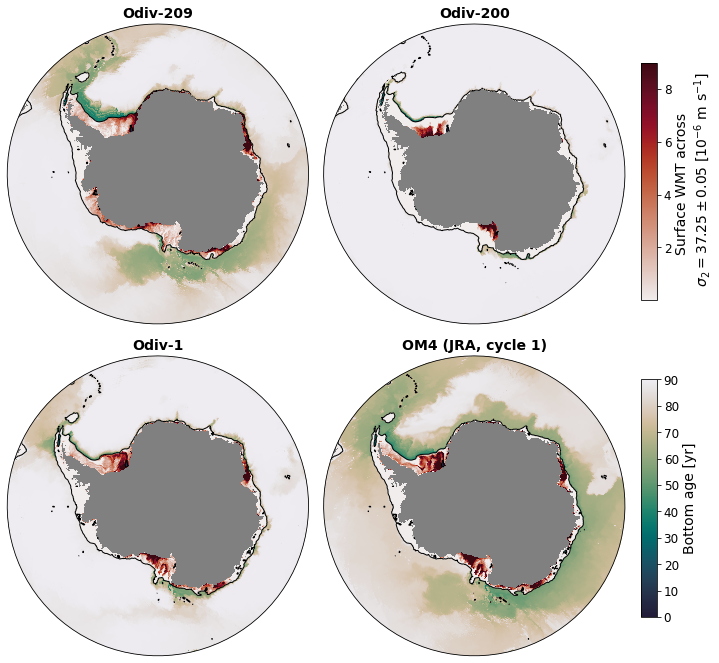

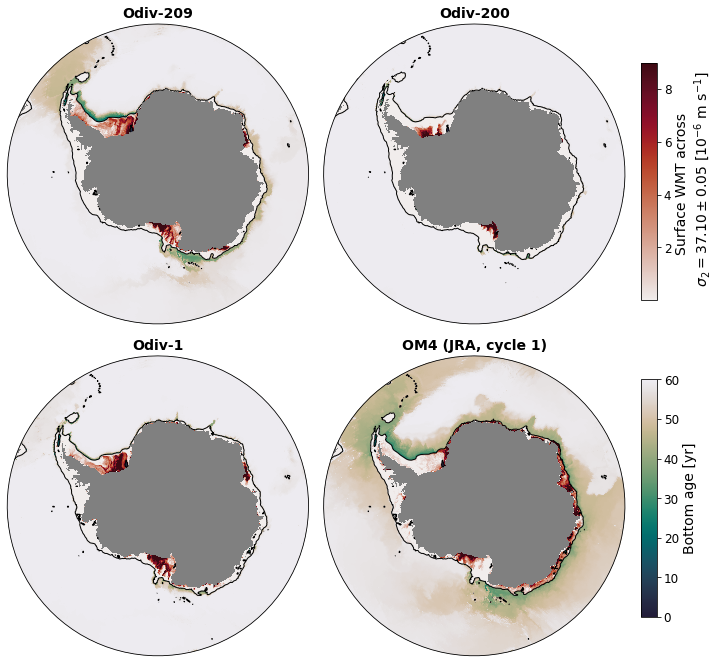

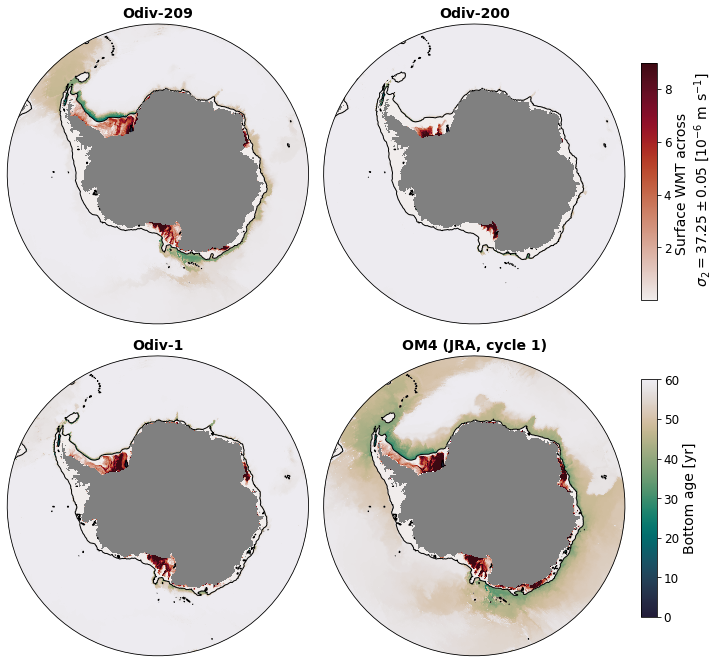

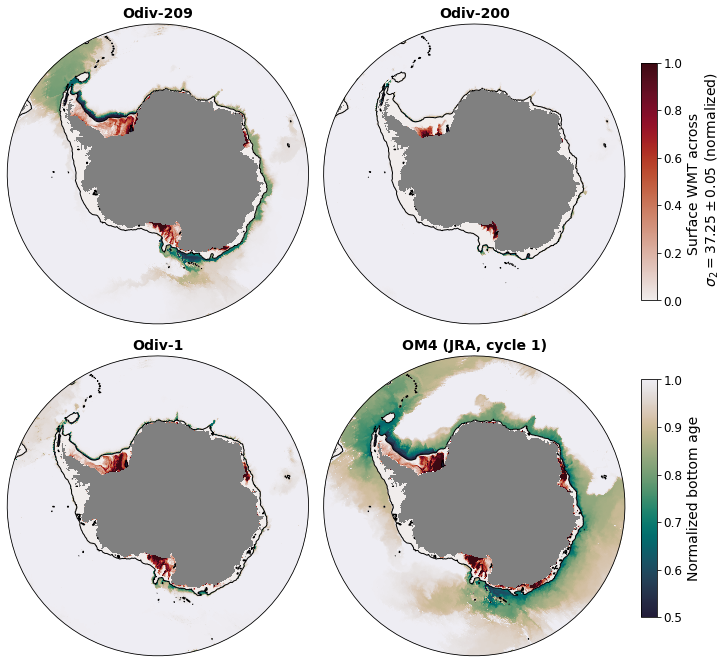

In [17]:
ageb_yr_cm4 = '0060'
ageb_yr_om4 = '2017'
mstr = ['Odiv-209','Odiv-200','Odiv-1','OM4 (JRA, cycle 1)']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11,11), subplot_kw=dict(projection=cartopy.crs.SouthPolarStereo(central_longitude=0.),
                                                                            facecolor='grey'))
fig.subplots_adjust(left=0.1, right=0.88, bottom=0.1, top=0.9, hspace=0.1, wspace=0.05)
for i, (ax, mod) in enumerate(zip(axes.flat, ddict)):
    ageb_yr = ageb_yr_cm4 if mod[:3]=='CM4' else ageb_yr_om4
    
    deptho = ddict[mod]['bottom_age_norm'].deptho
    wet = ddict[mod]['bottom_age_norm'].wet
    F = ddict[mod]['swmt']
    botage = ddict[mod]['bottom_age_norm'].bottom_age_norm.sel(time=ageb_yr).squeeze()
    
    #print(mod)
    ax.set_extent([-300, 60, -55, -90], cartopy.crs.PlateCarree())
    ax.set_boundary(circle, transform=ax.transAxes)
    deptho.plot.contour(ax=ax, x='x', y='y', levels=[1000.0], linewidths=1, colors='k', 
                        transform=cartopy.crs.PlateCarree())
    #if len(mod.split('_'))>2:
    #    continue
    #p1 = (F*1e5).plot(ax=ax, x='x', y='y', norm=mcolors.Normalize(vmin=0,vmax=1), cmap=cmo.amp, 
    #                  transform=cartopy.crs.PlateCarree(),add_labels=False, add_colorbar=False, zorder=1)
    p1 = (F*1e5).where((wet==1) & (deptho<1000)).plot(ax=ax, x='x', y='y', norm=mcolors.Normalize(vmin=0,vmax=1), cmap=cmo.amp, 
                                                      transform=cartopy.crs.PlateCarree(),add_labels=False, add_colorbar=False, zorder=1)
    p2 = botage.where(deptho>1000).plot(ax=ax, x='x', y='y', norm=mcolors.Normalize(vmin=0.5,vmax=1.0), cmap=cmo.rain_r, 
                                        transform=cartopy.crs.PlateCarree(), add_labels=False, add_colorbar=False, zorder=0)
    ax.set_title(mstr[i],fontsize=14, fontweight='bold')
    
cax1 = fig.add_axes([0.90, 0.55 , 0.02, 0.3])
cb = fig.colorbar(p1, cax=cax1, orientation='vertical', shrink=0.5, pad=0.2)
#cb.set_label('Surface WMT across \n $\sigma_%s=%.2f \pm %.2f$ (normalized)'%(lstr[-1],int(val)/100,int(dl)/100/2),fontsize=14)
cb.set_label('Surface WMT (normalized)'%(lstr[-1],int(val)/100,int(dl)/100/2),fontsize=14)
cb.ax.tick_params(labelsize=12)

cax2 = fig.add_axes([0.90, 0.15 , 0.02, 0.3])
cb = fig.colorbar(p2, cax=cax2, orientation='vertical', shrink=0.5, pad=0.2)
cb.set_label('Normalized bottom age',fontsize=14)
cb.ax.tick_params(labelsize=12)

#plt.savefig('/work/jet/figure.png', dpi=None, facecolor='w', edgecolor='w',
#            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

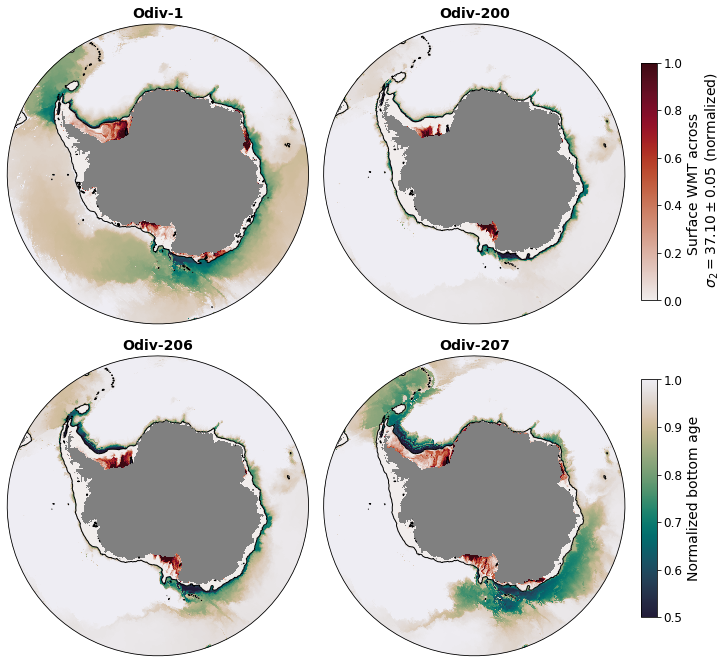

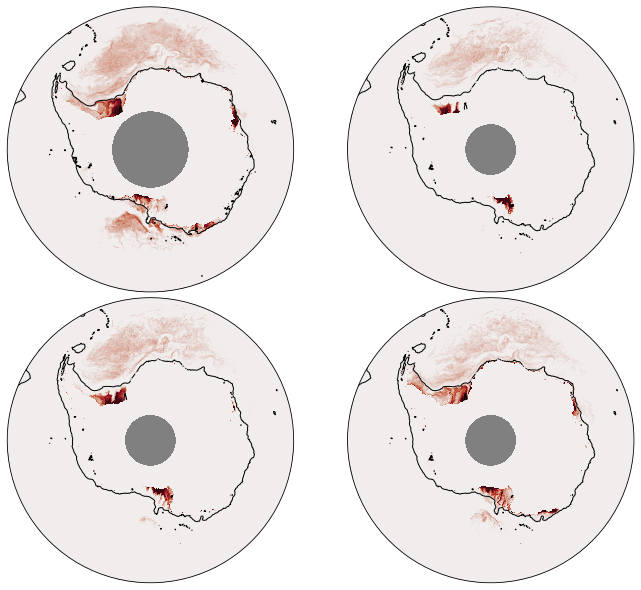

In [75]:
platfrom = 'gfdl.ncrc4-intel18-prod-openmp'
tprd = '019*'
yr_ed = '0200'
ddict = {mod:{} for mod in ['CM4_piControl','CM4_piControl_c192_OM4p125_v6_alt1','CM4_piControl_c192_OM4p125_v6_alt3']}
for mod in ddict:
    
    pp = 'ocean_annual_z_d2' if mod in ['CM4_piControl_c192_OM4p125_v5','CM4_piControl_c192_OM4p125_v6_alt1',
                                        'CM4_piControl_c192_OM4p125_v6_alt2'] else 'ocean_annual_z'
    pp_dir = '/pp/%s/ts/annual/10yr/'%pp
    
    rootdir = '/home/Jan-erik.Tesdal/data/raw/%s_C/ocean_annual_z/'%mod if mod=='CM4_piControl' \
                else '/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/%s/'%mod+platfrom+pp_dir if mod=='CM4_piControl_c192_OM4p25' \
                else '/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/%s/'%mod+platfrom+pp_dir
    print(rootdir)
    
    vars_ds = xr.open_mfdataset(rootdir+pp+'.%s.agessc.nc'%tprd, use_cftime=True, drop_variables=['average_DT','average_T1','average_T2'])
    vars_ds['volcello'] = xr.open_mfdataset(rootdir+pp+'.%s.volcello.nc'%tprd, use_cftime=True).volcello
    vars_ds['Kd_interface'] = xr.open_mfdataset(rootdir+pp+'.%s.Kd_interface.nc'%tprd, use_cftime=True).Kd_interface
    
    print(str(vars_ds.time.values[0])[:10],'to',str(vars_ds.time.values[-1])[:10])
    max_age_total = np.ceil(vars_ds.agessc[-1].max().values)
    print('Maximum age:',max_age_total,'years')
    
    grid = xr.open_dataset(rootdir[:-9]+'monthly/ocean_monthly.static.nc') if mod == 'CM4_piControl'\
            else xr.open_dataset(rootdir[:-15]+pp+'.static.nc')
    
    #print(pd.concat([vars_ds.xh.to_series().reset_index(drop=True), grid.xh.to_series().reset_index(drop=True), 
     #                vars_ds.yh.to_series().reset_index(drop=True), grid.yh.to_series().reset_index(drop=True)], axis=1))
    
    if mod in ['CM4_piControl_c192_OM4p125_v5','CM4_piControl_c192_OM4p125_v6_alt1','CM4_piControl_c192_OM4p125_v6_alt2']:
        grid = grid.assign_coords({'xh':vars_ds.xh,'yh':vars_ds.yh})
        
    ds = preprocessing(vars_ds, grid, decode_times=False, verbose=False)
    ds = ds.sel(time=slice(None,yr_ed))
    
    max_age = np.ceil(ds.agessc[-1].max().values)
    print('Maximum age:',max_age,'years')
    
    print(str(ds.time.values[0])[:10],'to',str(ds.time.values[-1])[:10])
    ds['dyt'] = grid.dyt.rename({'yh':'y', 'xh':'x'})
    with ProgressBar():
        ds['agefrac'] = agefrac_dxdz(ds,max_age).load()
         
    ddict[mod]['ds'] = ds
    ddict[mod]['max_age'] = max_age

0.1

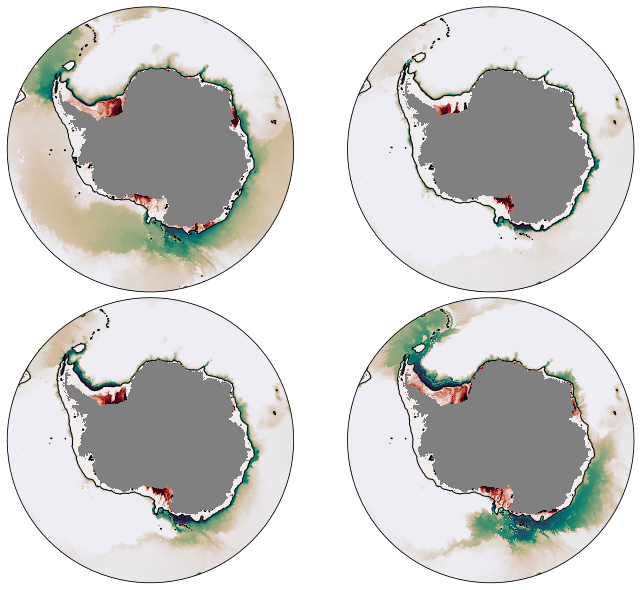